In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import shutil
import cv2
import os

### This notebook presents a brief exploration of the files that come with the dataset. 
### The objective is notebook is to:

    Explaining the .csv files from the .xml annotations so that the xml_to_csv.py 
    can be executed to generate the .csv files.       
    These files are needed to generate TFRecords.
    Explore the distribution of the classes present in the dataset. There are essentially three classes: Esophagitis, polyps       and ulcerative colitis
    Some additional notes regarding running the generate_tfrecord.py script.


### Conversion of XML files to CSV file format

In [2]:
import os
import glob
import pandas as pd
import xml.etree.ElementTree as ET


def xml_to_csv(path):
    xml_list = []
    for xml_file in glob.glob(path + '/*.xml'):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for member in root.findall('object'):
            value = (root.find('filename').text,
                     int(root.find('size')[0].text),
                     int(root.find('size')[1].text),
                     member[0].text,
                     int(member[4][0].text),
                     int(member[4][1].text),
                     int(member[4][2].text),
                     int(member[4][3].text)
                     )
            xml_list.append(value)
    column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df


def main():
    for directory in ['train', 'test']:
        image_path = os.path.join(os.getcwd(), 'D:/Shreya_docs/Kdata/images/{}'.format(directory))
        xml_df = xml_to_csv(image_path)
        xml_df.to_csv('D:/Shreya_docs/Kdata/data/{}_labels.csv'.format(directory), index=None)
print('Successfully converted both train and test xml files to csv.')


main()


Successfully converted both train and test xml files to csv.


In [3]:
train_df = pd.read_csv(r'D:\Shreya_docs\models\research\object_detection\data\train_labels.csv')
test_df = pd.read_csv(r'D:\Shreya_docs\models\research\object_detection\data\test_labels.csv')

In [4]:
train_df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,esophagitis1.jpg,1280,1024,esophagitis,333,622,612,834
1,esophagitis10.jpg,1280,1024,esophagitis,800,125,1153,383
2,esophagitis100.jpg,1280,1024,esophagitis,384,571,787,866
3,esophagitis101.jpg,1280,1024,esophagitis,923,188,1224,478
4,esophagitis102.jpg,1280,1024,esophagitis,740,203,1114,522


In [5]:
test_df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,esophagitis241.jpg,1280,1024,esophagitis,861,171,1217,556
1,esophagitis242.jpg,1280,1024,esophagitis,974,477,1243,817
2,esophagitis243.jpg,1920,1072,esophagitis,1169,10,1609,409
3,esophagitis244.jpg,1280,1024,esophagitis,792,430,1091,738
4,esophagitis245.jpg,1280,1024,esophagitis,749,86,1108,409


### Performing Exploratory Data Analysis for the KVASIR dataset.

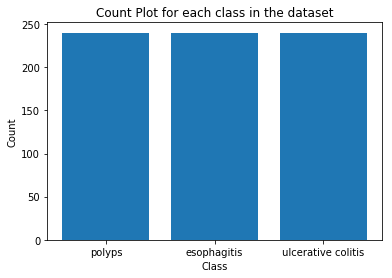

In [6]:
counts = train_df["class"].value_counts()
plt.bar(counts.index, counts.values)
plt.title("Count Plot for each class in the dataset")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

In [7]:
train_df["class"].value_counts()

polyps                240
esophagitis           240
ulcerative colitis    240
Name: class, dtype: int64

In [8]:
test_df["class"].value_counts()

polyps                60
esophagitis           60
ulcerative colitis    60
Name: class, dtype: int64

### Conversion of CSV file to TFRecords

In [9]:
from __future__ import division
from __future__ import print_function
from __future__ import absolute_import

import os
import io
import pandas as pd
import tensorflow.compat.v1 as tf

from PIL import Image
from object_detection.utils import dataset_util
from collections import namedtuple, OrderedDict

flags = tf.app.flags
flags.DEFINE_string('csv_input', 'D:/Shreya_docs/Kdata/data/test_labels.csv', 'Path to the CSV input')
flags.DEFINE_string('output_path', 'D:/Shreya_docs/Kdata/data/test.record', 'Path to output TFRecord')
flags.DEFINE_string('image_dir', 'D:/Shreya_docs/Kdata/images/test', 'Path to images')
FLAGS = flags.FLAGS


# label map
def class_text_to_int(row_label):
    if row_label == 'esophagitis':
        return 1
    if row_label == 'polyps':
        return 2
    if row_label == 'ulcerative colitis':
        return 3
    else:
        None


def split(df, group):
    data = namedtuple('data', ['filename', 'object'])
    gb = df.groupby(group)
    return [data(filename, gb.get_group(x)) for filename, x in zip(gb.groups.keys(), gb.groups)]


def create_tf_example(group, path):
    with tf.gfile.GFile(os.path.join(path, '{}'.format(group.filename)), 'rb') as fid:
        encoded_jpg = fid.read()
    encoded_jpg_io = io.BytesIO(encoded_jpg)
    image = Image.open(encoded_jpg_io)
    width, height = image.size

    filename = group.filename.encode('utf8')
    image_format = b'jpg'
    xmins = []
    xmaxs = []
    ymins = []
    ymaxs = []
    classes_text = []
    classes = []

    for index, row in group.object.iterrows():
        xmins.append(row['xmin'] / width)
        xmaxs.append(row['xmax'] / width)
        ymins.append(row['ymin'] / height)
        ymaxs.append(row['ymax'] / height)
        classes_text.append(row['class'].encode('utf8'))
        classes.append(class_text_to_int(row['class']))

    tf_example = tf.train.Example(features=tf.train.Features(feature={
        'image/height': dataset_util.int64_feature(height),
        'image/width': dataset_util.int64_feature(width),
        'image/filename': dataset_util.bytes_feature(filename),
        'image/source_id': dataset_util.bytes_feature(filename),
        'image/encoded': dataset_util.bytes_feature(encoded_jpg),
        'image/format': dataset_util.bytes_feature(image_format),
        'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
        'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
        'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
        'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
        'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
        'image/object/class/label': dataset_util.int64_list_feature(classes),
    }))
    return tf_example


def main(_):
    writer = tf.python_io.TFRecordWriter(FLAGS.output_path)
    path = os.path.join(FLAGS.image_dir)
    examples = pd.read_csv(FLAGS.csv_input)
    grouped = split(examples, 'filename')
    for group in grouped:
        tf_example = create_tf_example(group, path)
        writer.write(tf_example.SerializeToString())

    writer.close()
    output_path = os.path.join(os.getcwd(), FLAGS.output_path)
    print('Successfully created the Test TFRecords:')


if __name__ == '__main__':
    tf.app.run()


Successfully created the Test TFRecords:


SystemExit: 

c:\users\piu\anaconda3\envs\tensorflow1\lib\site-packages\IPython\core\interactiveshell.py:3334: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [10]:

import tensorflow.compat.v1 as tf2
flags = tf2.app.flags
flags.DEFINE_string('csv_input2', 'D:/Shreya_docs/Kdata/data/train_labels.csv', 'Path to the CSV input')
flags.DEFINE_string('output_path2', 'D:/Shreya_docs/Kdata/data/train.record', 'Path to output TFRecord')
flags.DEFINE_string('image_dir2', 'D:/Shreya_docs/Kdata/images/train', 'Path to images')
FLAGS = flags.FLAGS


# label map
def class_text_to_int2(row_label):
    if row_label == 'esophagitis':
        return 1
    if row_label == 'polyps':
        return 2
    if row_label == 'ulcerative colitis':
        return 3
    else:
        None


def split2(df, group):
    data = namedtuple('data', ['filename', 'object'])
    gb = df.groupby(group)
    return [data(filename, gb.get_group(x)) for filename, x in zip(gb.groups.keys(), gb.groups)]


def create_tf_example2(group, path):
    with tf.gfile.GFile(os.path.join(path, '{}'.format(group.filename)), 'rb') as fid:
        encoded_jpg = fid.read()
    encoded_jpg_io = io.BytesIO(encoded_jpg)
    image = Image.open(encoded_jpg_io)
    width, height = image.size

    filename = group.filename.encode('utf8')
    image_format = b'jpg'
    xmins = []
    xmaxs = []
    ymins = []
    ymaxs = []
    classes_text = []
    classes = []

    for index, row in group.object.iterrows():
        xmins.append(row['xmin'] / width)
        xmaxs.append(row['xmax'] / width)
        ymins.append(row['ymin'] / height)
        ymaxs.append(row['ymax'] / height)
        classes_text.append(row['class'].encode('utf8'))
        classes.append(class_text_to_int2(row['class']))

    tf_example2 = tf.train.Example(features=tf.train.Features(feature={
        'image/height': dataset_util.int64_feature(height),
        'image/width': dataset_util.int64_feature(width),
        'image/filename': dataset_util.bytes_feature(filename),
        'image/source_id': dataset_util.bytes_feature(filename),
        'image/encoded': dataset_util.bytes_feature(encoded_jpg),
        'image/format': dataset_util.bytes_feature(image_format),
        'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
        'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
        'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
        'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
        'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
        'image/object/class/label': dataset_util.int64_list_feature(classes),
    }))
    return tf_example2


def main(_):
    writer = tf.python_io.TFRecordWriter(FLAGS.output_path)
    path = os.path.join(FLAGS.image_dir)
    examples = pd.read_csv(FLAGS.csv_input)
    grouped = split2(examples, 'filename')
    for group in grouped:
        tf_example2 = create_tf_example2(group, path)
        writer.write(tf_example2.SerializeToString())

    writer.close()
    output_path = os.path.join(os.getcwd(), FLAGS.output_path)
    print('Successfully created the train TFRecords:')


if __name__ == '__main__':
    tf.app.run()


Successfully created the train TFRecords:


SystemExit: 